In [ ]:
!git clone https://github.com/parkerburchett/Numerai

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Numerai.SimpleScoreCalculator import NumeraiDataLoader
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'Numerai'...
remote: Enumerating objects: 1532, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (1347/1347), done.
remote: Total 1532 (delta 247), reused 1442 (delta 165), pack-reused 0
Receiving objects: 100% (1532/1532), 76.09 MiB | 26.63 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Mounted at /content/drive


### it appears that the sim scores follow this pattern:

This is a poission distribtion. see https://en.wikipedia.org/wiki/Poisson_distribution 

=
The dot product sim scores form this distribtion. That is worrisome I read, unsure yet on details, that it occurs when the undelrying process is random and independent. Eg not good for similarity. 


You can verify this by taking generateing 10 signatures of an era and then getting the sim score of each. Basicly check to see if there is mostly agreement. spot check with 1 and the pattern seems to mostly hold.

You should do a permuation test. (for one of the signatures, you should randomly permute one of the cols. then do the same test. 

In [ ]:
from Numerai.SimpleScoreCalculator import NumeraiDataLoader

dl = NumeraiDataLoader()
TRAIN_DF = dl.ping_training_data()
VALID_df = dl.ping_validation_data()

KeyboardInterrupt: ignored

In [ ]:
from Numerai.EraSignature import EraToSignature
ORTHODOX_FEATURE_PAIRS = pd.read_csv('/content/drive/MyDrive/othodox_feature_pairs.csv')
def compute_signatures(sig_size: int, offset=0,ORTHODOX_FEATURE_PAIRS=ORTHODOX_FEATURE_PAIRS, df=TRAIN_DF ):
  """ 
      Returns a dataframe of signatures. based on the list of feature pairs you pass into the dataframe.
      sig_size: int: the number of feature pairs to use for the signature
      offset: how many ints forward to move in the sample. 
      ORTHODOX_FEATURE_PAIRS: a list of feature pairs. Read from memory to have a fixed order. 
      df: the DataFrame with the order in it
  """
  sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[offset:offset+sig_size]) # init a sigWriter object
  sig_dict = {}
  for era_num in df['era'].unique():
    sig_dict[era_num] = sig_writer.derive_era_signature(df[df['era']==era_num])
  return sig_dict
 
 
def compute_sum_square_residual(sig_a,sig_b) -> float:
  """
    Returns the sum of the squared residual between sig_a and sig_b.
    High residuals = dissimilar. 
  """
  if sig_a.shape != sig_b.shape:
    raise ValueError('You cannot compute_sum_square_residual on different sized Era Signatures')
  squre_residual_matrix = np.square(sig_a.values - sig_b.values)
  return np.sum(squre_residual_matrix)
 
 
def get_k_most_similar_eras(taget_sig: pd.DataFrame, sig_dict:dict, K=20) -> list:
  """
    Returns a list of the K most similar era
    taget_sig: a Signature df created by the same writer to the one that sig_dict.
  """
  era_similarity = []

  for era in sig_dict.keys():
    era_similarity.append((era,compute_sum_square_residual(sig_dict[era], target_sig)))

  era_similarity.sort(key= lambda x: x[1])
  k_most_similar_eras = [x[0] for x in era_similarity[:K]]
  return k_most_similar_eras
 



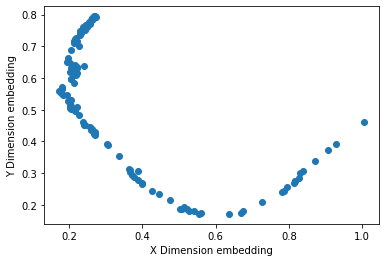

CPU times: user 53.7 s, sys: 1.01 s, total: 54.7 s
Wall time: 53.5 s


In [ ]:
%%time
import sklearn.cluster as cluster
big_sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[500:600])
train_era_sigs = {}
flat_sigs =[]
for era in TRAIN_DF['era'].unique():
  train_df_subset = TRAIN_DF[TRAIN_DF['era'] == era]
  signature = big_sig_writer.derive_era_signature(train_df_subset)
  flat_signature = signature.values.flatten()
  train_era_sigs[era] = flat_signature
  flat_sigs.append(flat_signature)

model = cluster.KMeans(2) 
res = model.fit_transform(flat_sigs)
plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.xlabel('X Dimension embedding')
plt.ylabel('Y Dimension embedding')
plt.show()


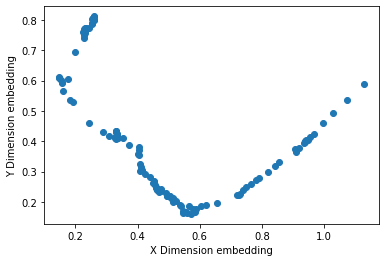

In [ ]:

big_sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[800:900])
train_era_sigs = {}
flat_sigs =[]
for era in TRAIN_DF['era'].unique():
  train_df_subset = TRAIN_DF[TRAIN_DF['era'] == era]
  signature = big_sig_writer.derive_era_signature(train_df_subset)
  flat_signature = signature.values.flatten()
  train_era_sigs[era] = flat_signature
  flat_sigs.append(flat_signature)

model = cluster.KMeans(2) 
res = model.fit_transform(flat_sigs)
plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.xlabel('X Dimension embedding')
plt.ylabel('Y Dimension embedding')
plt.show()

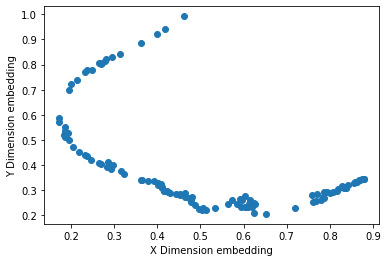

In [ ]:
big_sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[1200:1300])
train_era_sigs = {}
flat_sigs =[]
for era in TRAIN_DF['era'].unique():
  train_df_subset = TRAIN_DF[TRAIN_DF['era'] == era]
  signature = big_sig_writer.derive_era_signature(train_df_subset)
  flat_signature = signature.values.flatten()
  train_era_sigs[era] = flat_signature
  flat_sigs.append(flat_signature)

model = cluster.KMeans(2) 
res = model.fit_transform(flat_sigs)
plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.xlabel('X Dimension embedding')
plt.ylabel('Y Dimension embedding')
plt.show()

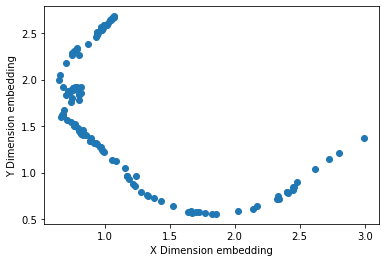

CPU times: user 9min 55s, sys: 6.68 s, total: 10min 2s
Wall time: 9min 55s


In [ ]:
%%time
big_sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[1200:2300])
train_era_sigs = {}
flat_sigs =[]
for era in TRAIN_DF['era'].unique():
  train_df_subset = TRAIN_DF[TRAIN_DF['era'] == era]
  signature = big_sig_writer.derive_era_signature(train_df_subset)
  flat_signature = signature.values.flatten()
  train_era_sigs[era] = flat_signature
  flat_sigs.append(flat_signature)

model = cluster.KMeans(2,precompute_distances=True) 
res = model.fit_transform(flat_sigs)
plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.xlabel('X Dimension embedding')
plt.ylabel('Y Dimension embedding')
plt.show()

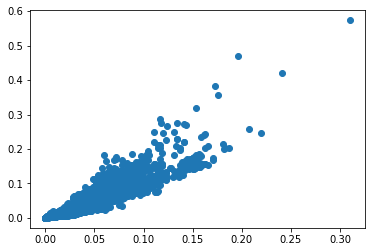

In [ ]:
cluster_centers  = model.cluster_centers_
plt.scatter(x=[a for a in cluster_centers[0]], y =[a for a in cluster_centers[1]] )
plt.show()

In [ ]:
cluster_centers # these are the points in the 'center' of N-demensional space. 


array([[0.03160426, 0.02470133, 0.07860758, ..., 0.04116986, 0.03947272,
        0.03619059],
       [0.01465858, 0.01359942, 0.12103563, ..., 0.03721521, 0.03321123,
        0.0306226 ]])

### See where the Live Tournament Eras get embedded into the 2d clustering space. 

In [ ]:
%%time
TOURNAMENT_DF = dl.ping_tournament_data()

Traceback (most recent call last):
  File "/content/Numerai/SimpleScoreCalculator.py", line 364, in ping_tournament_data
    valid_df["era"] = valid_df["era"].apply(lambda x: int(x[3:])) # strip the word 'era' from the era column and cast as an int
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/series.py", line 4213, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/lib.pyx", line 2403, in pandas._libs.lib.map_infer
  File "/content/Numerai/SimpleScoreCalculator.py", line 364, in <lambda>
    valid_df["era"] = valid_df["era"].apply(lambda x: int(x[3:])) # strip the word 'era' from the era column and cast as an int
ValueError: invalid literal for int() with base 10: 'X'


CPU times: user 4min 36s, sys: 22 s, total: 4min 58s
Wall time: 5min 2s


In [ ]:
TOURNAMENT_DF['era'].unique()

array(['era121', 'era122', 'era123', 'era124', 'era125', 'era126',
       'era127', 'era128', 'era129', 'era130', 'era131', 'era132',
       'era575', 'era576', 'era577', 'era578', 'era579', 'era580',
       'era581', 'era582', 'era583', 'era584', 'era585', 'era586',
       'era587', 'era588', 'era589', 'era590', 'era591', 'era592',
       'era593', 'era594', 'era595', 'era596', 'era597', 'era598',
       'era599', 'era600', 'era601', 'era602', 'era603', 'era604',
       'era605', 'era606', 'era607', 'era608', 'era609', 'era610',
       'era611', 'era612', 'era613', 'era614', 'era615', 'era616',
       'era617', 'era618', 'era619', 'era620', 'era621', 'era622',
       'era623', 'era624', 'era625', 'era626', 'era627', 'era628',
       'era629', 'era630', 'era631', 'era632', 'era633', 'era634',
       'era635', 'era636', 'era637', 'era638', 'era639', 'era640',
       'era641', 'era642', 'era643', 'era644', 'era645', 'era646',
       'era647', 'era648', 'era649', 'era650', 'era651', 'era6

In [ ]:
a_era = TOURNAMENT_DF[TOURNAMENT_DF['era'] == 'era602']
tournament_sig = big_sig_writer.derive_era_signature(a_era)
flat_tournament_signature = tournament_sig.values.flatten()
point = model.transform([flat_tournament_signature])

plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.xlabel('X Dimension embedding')
plt.ylabel('Y Dimension embedding')
plt.show()

#https://stackoverflow.com/questions/53630158/add-points-to-the-existing-matplotlib-scatter-plot 


array([[1.06879604, 2.64178831]])

call 0 of 340 ish
call 10 of 340 ish
call 20 of 340 ish
call 30 of 340 ish
call 40 of 340 ish
call 50 of 340 ish
call 60 of 340 ish
call 70 of 340 ish
call 80 of 340 ish
call 90 of 340 ish
call 100 of 340 ish
call 110 of 340 ish
call 120 of 340 ish
call 130 of 340 ish
call 140 of 340 ish
call 150 of 340 ish
call 160 of 340 ish
call 170 of 340 ish
call 180 of 340 ish
call 190 of 340 ish
call 200 of 340 ish
call 210 of 340 ish
call 220 of 340 ish
call 230 of 340 ish
call 240 of 340 ish
call 250 of 340 ish
call 260 of 340 ish
call 270 of 340 ish
call 280 of 340 ish
call 290 of 340 ish
call 300 of 340 ish
call 310 of 340 ish
call 320 of 340 ish
call 330 of 340 ish
call 340 of 340 ish


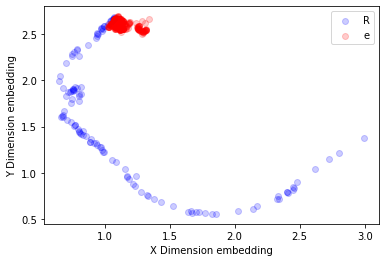

CPU times: user 29min 43s, sys: 8.95 s, total: 29min 52s
Wall time: 29min 41s


In [ ]:
%%time
x_list = []
y_list = []
for i , t in enumerate(TOURNAMENT_DF['era'].unique()):
  tournament_era_subset = TOURNAMENT_DF[TOURNAMENT_DF['era'] == t]
  tournament_sig = big_sig_writer.derive_era_signature(tournament_era_subset)
  flat_tournament_signature = tournament_sig.values.flatten()
  point = model.transform(flat_tournament_signature.reshape(1,-1)) # this embeddes it in the cluster distance space
  x_list.append(point[0][0])
  y_list.append(point[0][1])
  if i % 10 == 0:
    print(f'call {i} of 340 ish')


plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res], color='blue', alpha=.2) # res stores the embedding of the training data
plt.scatter(x=x_list, y=y_list, color='red', alpha=.2)
plt.xlabel('X Dimension embedding')
plt.ylabel('Y Dimension embedding')
plt.legend('Red are embedded Training Data, Blue is embeded Tournament Data')
plt.show() # should take 25 minutes to run


[2.6081892736149093, 2.6232196162715606]

SyntaxError: ignored

# Jaccard Similarity between K most similar eras

This is to see how good the signatures are accross different eras.












a
a
a

a
aa
a
a

a
a
aa
a
a
da

In [ ]:
%%time

k_most_similar_first_sig_dict = {}

for target_era in TRAIN_DF['era'].unique():
  target_sig = sig_dict[target_era]
  k_most_similar_first_sig_dict[target_era] = get_k_most_similar_eras(target_sig, sig_dict,K=30)

k_most_similar_second_sig_dict = {}

for target_era in TRAIN_DF['era'].unique():
  target_sig = sig_dict_v2[target_era]
  k_most_similar_second_sig_dict[target_era] = get_k_most_similar_eras(target_sig, sig_dict_v2, K=30)
  # print(get_k_most_similar_eras(target_sig, sig_dict))

In [ ]:
jaccards = []
for era in TRAIN_DF['era'].unique():
  sig_1_similar_eras = set(k_most_similar_second_sig_dict[era])
  sig_2_similar_eras = set(k_most_similar_first_sig_dict[era])
  # print(sig_1_similar_eras)
  # print(sig_2_similar_eras)
  num_interection = len(sig_1_similar_eras.intersection(sig_2_similar_eras))
  num_union = len(sig_1_similar_eras.union(sig_2_similar_eras))
  jaccard_sim = num_interection / num_union
  jaccards.append([era,jaccard_sim])

pd.DataFrame(jaccards)[1].mean() # average on training set jaccard similiarty of 30 most similar eras. 

In [ ]:
%%time
TOURNAMENT_DF = dl.ping_tournament_data()

### lets look at the Jaccard sim on the Tournament Dataset


In [ ]:
%%time
tournament_sig_dict = compute_signatures(sig_size=1000, df=TOURNAMENT_DF) # signatures take 25 minutes when len is 1_000  I don't really have to optimized this. 
tournament_sig_dict_v2 = compute_signatures(sig_size=1000,offset=2000, df=TOURNAMENT_DF) # these are done with st

In [ ]:
tournament_sig_dict.keys()

In [ ]:

tournament_era = 'era759'
line_points = []
eras = []
for i in range(1,100):
  point = compute_sum_square_residual(sig_dict[i], tournament_sig_dict[tournament_era])
  line_points.append(point)
  eras.append(i)



plt.plot(x=np.array(line_points),y=np.array(eras), linestyle = 'dotted', kind='scatter')
plt.xlabel('TrainingEra')
plt.ylabel('Sum Square Residule')
plt.title(f'residual with training era signautres for trounament era {tournament_era}')
plt.show()


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

In [ ]:
%%time

all_lines = []
for tournament_era in TOURNAMENT_DF['era'].unique():
  line_points = []
  for i in range(1,120):
    point = compute_sum_square_residual(sig_dict[i], tournament_sig_dict[tournament_era])
    line_points.append(point)
    
  plt.plot(np.array(line_points), linestyle = 'dotted')
  plt.xlabel('TrainingEra')
  plt.ylabel('Sum Square Residule')
  plt.title(f'residual with training era signautres for trounament era {tournament_era}')
  plt.show()
  all_lines.append(line_points)

all_residuals = pd.DataFrame(all_lines)

In [ ]:
len(TOURNAMENT_DF['era'].unique())

In [ ]:
all_residuals.index # index is the tournament


In [ ]:


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(all_residuals)

These lines have essentialy the same slope just a shift up or a shift down. I don't know why this happens. 

The X-axis is the tournament df era, the Y-axis is the Residual

In all_residuals the Columns are The Training Eras. The rows are the Trounament Eras. 

In [ ]:
import seaborn as sns
sample_all_res = all_residuals.loc[50,:] # residule for a 

sns.scatterplot(data=sample_all_res)

In [ ]:
plt.plot(all_residuals.mean())

# Signature Emeddings


In [ ]:
import sklearn.cluster as cluster

small_sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[0:10])

train_era_sigs = {}
flat_sigs =[]
for era in TRAIN_DF['era'].unique():
  train_df_subset = TRAIN_DF[TRAIN_DF['era'] == era]
  signature = small_sig_writer.derive_era_signature(train_df_subset)
  flat_signature = signature.values.flatten()
  train_era_sigs[era] = flat_signature
  flat_sigs.append(flat_signature)
  
model = cluster.KMeans(2) 
res = model.fit_transform(flat_sigs)
plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.show()

In [ ]:
big_sig_writer = EraToSignature(ORTHODOX_FEATURE_PAIRS.loc[100:300])

train_era_sigs = {}
flat_sigs =[]
for era in TRAIN_DF['era'].unique():
  train_df_subset = TRAIN_DF[TRAIN_DF['era'] == era]
  signature = big_sig_writer.derive_era_signature(train_df_subset)
  flat_signature = signature.values.flatten()
  train_era_sigs[era] = flat_signature
  flat_sigs.append(flat_signature)

model = cluster.KMeans(8) 
res = model.fit_transform(flat_sigs)
plt.scatter(x=[a[0] for a in res], y=[a[1] for a in res])
plt.show()
plt.scatter(x=[a[0] for a in res], y=[a[2] for a in res])
plt.show()
plt.scatter(x=[a[1] for a in res], y=[a[2] for a in res])
plt.show()
